# Pré-processamento dos Dados

## 1. Criação do data set 

In [1]:
# libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# FUNCTIONS #

#function to plot in and target data
def plotData(data, names):
    plt.figure()
    n_graphs = len(data.T)
    for i in range(n_graphs):
        plt.subplot(n_graphs,1,i+1)
        plt.plot(data[names[i]])
        plt.ylabel(names[i])

#function to scale the dataset
def scaleData(data):
    s_data = data.copy()
    l = len(s_data.T)
    for i in range(l):
        s_data.iloc[:,i] = ((data.iloc[:,i] - data.iloc[:,i].min())
                          / (data.iloc[:,i].max() - data.iloc[:,i].min()))
    return s_data

#function to standardize the dataset
def standardizeData(data):
    s_data = data.copy()
    l = len(s_data.T)
    for i in range(l):
        s_data.iloc[:,i] = ((data.iloc[:,i] - data.iloc[:,i].mean())
                          / data.iloc[:,i].std())
    
    return s_data

def reStandData(data,y,n_inputs,n_outputs):
    s_y = y.copy()
    outs = data.iloc[:,n_inputs:n_inputs+n_outputs]
    y_m = np.matrix(y)
    l = len(outs.T)
    for i in range(l):
        s_y = y_m[i,:] * outs.iloc[:,i].std() + outs.iloc[:,i].mean()
        
    
    return np.array(s_y)

def plotOutputs(data, y, n_inputs, n_outputs):
    outs = data.iloc[:,n_inputs:n_inputs+n_outputs]
    plt.plot(outs.iloc[:,0],color="blue") 
    plt.plot(y[0,:], color="red")
    plt.ylabel(outs.columns[0]), plt.xlabel('Sample');

def addFeatures(data, n, names):
    l = len(data.T)
    for i in range(l):
        for j in range(n):
            #names for delayed inputs
            #Ex: Input Gas Rate (-1)...
            txt = names[i]+' (-'+str(j+1)+')'
            if j == 0:
                data[txt] = data[names[i]].shift(periods=1)
            else:
                txt2 = names[i]+' (-'+str(j)+')'
                data[txt] = data[txt2].shift(periods=1)
            
            data.loc[0,txt] = data.loc[1,txt]
            
        
    
    return data
            

def getPairs(fData, n_inputs, n_outputs):
    x = fData.iloc[:,0:n_inputs]
    delayed_x = fData.iloc[:,n_outputs+1:]
    X = pd.concat([x,delayed_x], axis=1)
    y = fData.iloc[:,n_inputs:n_inputs+n_outputs]
    return X,y

    

#path to access the dataset .txt or .csv
path = '../Data/Online Prediction/Box-Jenkins_Gas-furnace.txt'

#names of the input and target data
names = ['Input Gas Rate', 
         'CO2 (%)']

data = pd.read_csv(path, header=None, names=names)

#it shows n=2 pairs input-target. Useful to test if dataset was successfully created
#data.head(2)
scaledData = scaleData(data)
standardizedData = standardizeData(data)

#plotData(scaledData,names)
#plotData(standardizedData,names)

delayed_order = 4

featuredData = addFeatures(standardizedData,delayed_order,names)

featuredData.head(3)
    

/Users/jeanmarioml/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/jeanmarioml/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


,Input Gas Rate,CO2 (%),Input Gas Rate (-1),Input Gas Rate (-2),Input Gas Rate (-3),Input Gas Rate (-4),CO2 (%) (-1),CO2 (%) (-2),CO2 (%) (-3),CO2 (%) (-4)
0,-0.048627,0.090839,-0.048627,-0.048627,-0.048627,-0.048627,0.090839,0.090839,0.090839,0.090839
1,0.052979,0.028381,-0.048627,-0.048627,-0.048627,-0.048627,0.090839,0.090839,0.090839,0.090839
2,0.218906,-0.002849,0.052979,-0.048627,-0.048627,-0.048627,0.028381,0.090839,0.090839,0.090839


## Treinamento com ANN MLP

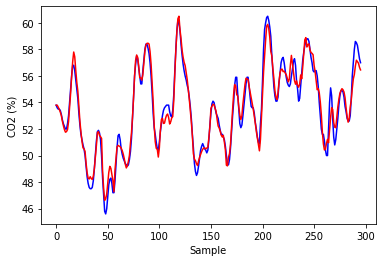

In [2]:
# Train and estimate model performance
from sklearn.model_selection import cross_val_predict
# Import neural network for regression
from sklearn.neural_network import MLPRegressor
# Import function for cross-validation
from sklearn.model_selection import cross_val_score

# Define neural network architecture
# Two hidden layers with three neurons each
mlp = MLPRegressor(hidden_layer_sizes=(18))
y_pred = cross_val_predict(mlp,
                           featuredData[['Input Gas Rate', 
                                                     'Input Gas Rate (-1)', 
                                                     'Input Gas Rate (-2)',
                                                     'Input Gas Rate (-3)', 
                                                     'CO2 (%) (-1)', 
                                                     'CO2 (%) (-2)', 
                                                     'CO2 (%) (-3)']],
                           featuredData.iloc[:,1],
                           cv=10)
  


# Rescale prediction
y_pred = (y_pred
          * data['CO2 (%)'].std()
         + data['CO2 (%)'].mean())

# Plot CO2 series
plt.plot(data['CO2 (%)'], color='blue')
plt.plot(y_pred, color='red')
plt.ylabel('CO2 (%)'), plt.xlabel('Sample');


    


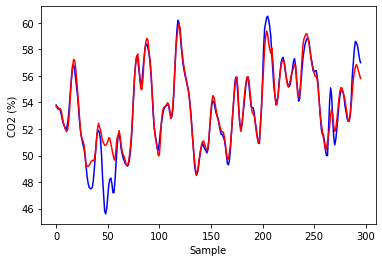

In [3]:
# Train and estimate model performance
from sklearn.model_selection import cross_val_predict
# Import neural network for regression
from sklearn.neural_network import MLPRegressor
# Import function for cross-validation
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVR


#number of inputs and outputs of the model
n_inputs = 1
n_outs = 1

#net parameters
n_neurons = 18
cv = 10


#pairs of data X (input) and y (target)
X,y = getPairs(featuredData,n_inputs, n_outs)

#mlp with 1 hidden layer and 18 neurons 
mlp = MLPRegressor(hidden_layer_sizes=(n_neurons))
#y_pred = cross_val_predict(mlp,X,y,cv=cv)
y_pred = cross_val_predict(SVR(),X,y,cv=cv)

# Rescale prediction
#y_pred = (y_pred
#          * data['CO2 (%)'].std()
#         + data['CO2 (%)'].mean())

y_pred = reStandData(data,y_pred,1,1)

# Plot CO2 series
#plt.plot(data['CO2 (%)'], color='blue')
#plt.plot(y_pred[0,:], color='red')
#plt.ylabel('CO2 (%)'), plt.xlabel('Sample');

plotOutputs(data,y_pred,1,1)


In [4]:
y

,CO2 (%)
0,0.090839
1,0.028381
2,-0.002849
3,-0.002849
4,-0.034078
...,...
291,1.558617
292,1.496158
293,1.340011
294,1.183865


In [15]:
outs.iloc[:,0]

0      53.8
1      53.6
2      53.5
3      53.5
4      53.4
       ... 
291    58.5
292    58.3
293    57.8
294    57.3
295    57.0
Name: CO2 (%), Length: 296, dtype: float64

In [18]:
outs.columns[0]

'CO2 (%)'